<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/ToyModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy models for forecasting day-ahead electricity prices

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Load one of the included datasets - EPEX or GEFCom

In [4]:
dataset = "epex" # "epex" or "gefcom" 
url = f"https://raw.githubusercontent.com/lipiecki/energy-analytics-2025/refs/heads/main/data/{dataset}.csv"
local = f"../data/{dataset}.csv"

In [5]:
df = pd.read_csv(url, delimiter=',', header=0, index_col=[0, 1]) # use `local` instead or `url` when running the notebook offline
df

price   load_da  load_real  day_of_week
date     hour                                          
20220101 0      50.05  41989.50   43915.50            6
         1      41.33  40105.50   41535.75            6
         2      43.22  38784.00   40480.75            6
         3      45.46  37751.00   39564.00            6
         4      37.67  37877.25   39338.25            6
...               ...       ...        ...          ...
20241231 19    200.00  56083.25   54868.50            2
         20    204.61  53423.00   51940.50            2
         21    186.25  50937.50   50559.50            2
         22    146.52  47657.50   49133.50            2
         23    141.68  45257.25   49607.50            2

[26304 rows x 4 columns]

### Select the starting date and the number of days for the forecasting period

In [6]:
date = 20240513
ndays = 7

### Prepare the explanatory variables for the regression models

In [7]:
# create lag columns for prices from previous days
df['lag1'] = df['price'].shift(24)  # price one day ago (24 hours)
df['lag2'] = df['price'].shift(48)  # price two days ago (48 hours)
df['lag7'] = df['price'].shift(168) # price seven days ago (168 hours)
df.dropna(inplace=True)
df


price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20220108 0     164.17  51093.00   52694.75            6  128.92   99.85   
         1     152.83  49105.50   50532.50            6  118.40  101.32   
         2     166.00  48075.25   49608.25            6  103.01  110.01   
         3     160.86  47763.50   49543.25            6  101.91  111.55   
         4     160.00  47900.25   49077.25            6  101.98  123.37   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  
date     hour          
20220108 0      50.05  
         1      41.33  
         2      43.22  
         3      45.46  
         4      37.67  
...               ...  
20241231 19    105.66  
         20    102.56  
         21     94.63  
         22     99.04  
         23     90.00  

[26136 rows x 7 columns]

### Generate naive forecasts
Take the price from one day ago or a week ago, depending on the day of the week

In [8]:
# function to generate forecast based on current day of the week
def generate_naive(row):
    if row['day_of_week'] > 1 and row['day_of_week'] <= 5:  # Tuesday to Friday
        return row['lag1']
    else:  # Saturday to Monday
        return row['lag7']

# apply the function to each row to generate the naive forecast
df['naive_forecast'] = df.apply(generate_naive, axis=1)

### Select the length of the training window
358 days corresponds to using the data from 365 previous days (due to the 7-day lag)

In [9]:
window = 358

### Select explanatory variables for the model
And cast the data to an array format

In [10]:
X = np.array(df[['lag1', 'lag2', 'lag7', 'load_da']])
Y = np.array(df['price'])

### Find the index corresponding to the first date of or forecasting period

In [11]:
idx = df.index.get_loc((date, 0))

### Generate forecasts using linear regression
AutoRegressive with eXogenuous variables (ARX)

In [12]:
df['arx_forecast'] = np.nan
for i in range(idx, idx+24*ndays):
      # prepare training data
      X_window = X[i-window*24:i:24, :]
      Y_window = Y[i-window*24:i:24]

      # fit the model to training data
      arx = LinearRegression()
      arx = arx.fit(X_window, Y_window)

      # prepare inputs for the next day and hour
      X_next = X[i, :]

      # predict
      df.iloc[i, df.columns.get_loc('arx_forecast')] = arx.predict([X_next])

### Generate forecasts using artificial neural network
Nonlinear AutoRegressive with eXogenuous variables (NARX)

In [13]:
df['narx_forecast'] = np.nan
for i in range(idx, idx+24*ndays):
      # prepare training data
      X_window = X[i-window*24:i:24, :]
      Y_window = Y[i-window*24:i:24]

      # scale training inputs
      input_scaler = StandardScaler().fit(X_window)
      X_window = input_scaler.transform(X_window)

      # fit the model to training data
      narx = MLPRegressor((5, ), activation='tanh', solver="adam",
                          learning_rate_init=0.1, early_stopping=True,
                          validation_fraction=0.1, max_iter=1000, batch_size=32,
                          random_state=42)
      narx = narx.fit(X_window, Y_window)

      # inputs for the next day and hour
      X_next = X[i, :]
      X_next = input_scaler.transform([X_next])

      # predict
      df.iloc[i, df.columns.get_loc('narx_forecast')] = narx.predict(X_next)

### Define functions for the Holt-Winters exponential smoothing model

In [14]:
def holtwinters(params, s, obs):
    """
    Calculates forecasts using Holt-Winters exponential smoothing.

    Args:
        params (tuple): parameters in the form of a 3-tuple (alpha, beta, gamma)
        s (int): seasonality period
        obs (1d numpy array): observed values of the timeseries to forecast

    Returns:
        2-tuple of 1d numpy arrays: first element is the array of forecasts, second is the array of corresponding observations
    """
    alpha, beta, gamma = params
    level = np.zeros(len(obs))
    trend = np.zeros(len(obs))
    season = np.zeros(len(obs))
    forecast = np.zeros(len(obs))

    # set initial values
    level[s-1] = np.mean(obs[:s])
    trend[s-1] = (np.mean(obs[s:2*s]) - np.mean(obs[:s]))/s
    season[:s] = obs[:s] - level[s-1]

    # iteratively compute consecutive forecasts
    for t in range(s, len(obs)-1):
        level[t] = alpha*(obs[t] - season[t-s]) + (1-alpha)*(level[t-1] + trend[t-1])
        trend[t] = beta*(level[t] - level[t-1]) + (1-beta)*trend[t-1]
        season[t] = gamma*(obs[t] - level[t]) + (1-gamma)*season[t-s]
        forecast[t+1] = level[t] + trend[t] + season[t-s+1]

    # return forecasts starting from the (2s+1)-th timestep
    return forecast[2*s:]

def loss_hw(params, s, obs):
    """
    Calculates the mean of squared residuals for Holt-Winters model with parameters specified by `params`.
    """
    forecasts = holtwinters(params, s, obs)
    return mean_squared_error(forecasts, obs[2*s:])

def calibrate_hw(s, obs):
    """
    Find optimal parameters for the Holt-Winters model.
    """
    opt_params = optimize.minimize(loss_hw, (0.5, 0.5, 0.5), args = (s, obs), bounds = ((0, 1), (0, 1), (0, 1)))
    return opt_params.x

### Generate forecasts using Holt-Winters model

In [15]:
season = 7 # set the seasonality period to 7, because we expect the electricty prices to exhibit weekly seasonality
df['hw_forecast'] = np.nan
for i in range(idx, idx+24*ndays):
      Y_window = Y[i-window*24:i:24]
      optimal_params = calibrate_hw(season, Y_window)
      df.iloc[i, df.columns.get_loc('hw_forecast')] = holtwinters(optimal_params, season, np.hstack((Y_window, Y[i])))[-1]

### Remove days without forecasts

In [16]:
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20240513 0      56.53  41850.75   40541.50            1   64.42   93.76   
         1      49.87  40107.00   39573.25            1   53.22   91.29   
         2      40.76  39942.25   39292.75            1   43.78   87.22   
         3      41.98  40259.00   39460.00            1   40.36   86.20   
         4      49.65  42074.25   40953.50            1   45.07   87.00   
...               ...       ...        ...          ...     ...     ...   
20240519 19    102.95  44411.50   42465.75            7  111.89  128.46   
         20    139.39  44013.50   41768.50            7  137.35  149.07   
         21    123.82  43862.00   41496.00            7  124.82  111.94   
         22    101.31  43467.50   40535.75            7   99.56   96.58   
         23     85.60  40778.00   38059.00            7   93.89   86.97   

                 lag7  naive_forecast  arx_forecast  narx_forecast  \
date     hour                                                        
20240513 0      82.86           82.86     71.139455      78.665700   
         1      77.94           77.94     62.295738      68.127103   
         2      78.43           78.43     56.023204      60.099460   
         3      78.13           78.13     52.657754      59.103312   
         4      79.97           79.97     55.620570      59.883955   
...               ...             ...           ...            ...   
20240519 19     88.72           88.72    102.163423     103.212325   
         20    142.22          142.22    131.188554     132.019879   
         21     89.48           89.48    110.351525     118.505339   
         22     75.69           75.69     92.674239     102.947665   
         23     74.99           74.99     86.827640      91.972876   

               hw_forecast  
date     hour               
20240513 0       75.467944  
         1       73.813683  
         2       69.874746  
         3       70.754959  
         4       75.271228  
...                    ...  
20240519 19      95.770981  
         20     127.738752  
         21     111.894411  
         22      90.141486  
         23      84.784185  

[168 rows x 11 columns]

### Plot the price timeseries along with the generated forecasts

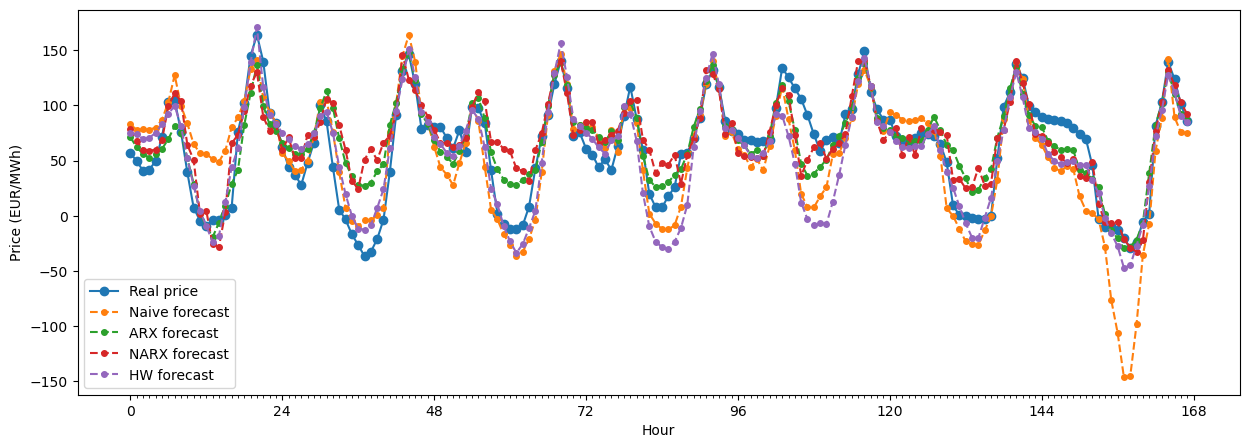

In [17]:
# plot real price and forecasts
hours = range(0, 24*ndays)
plt.figure(figsize=(15, 5))
plt.plot(hours, np.array(df['price']), '-o', label='Real price')
plt.plot(hours, np.array(df['naive_forecast']), '--o', label='Naive forecast', markersize=4)
plt.plot(hours, np.array(df['arx_forecast']), '--o', label='ARX forecast', markersize=4)
plt.plot(hours, np.array(df['narx_forecast']),'--o', label='NARX forecast', markersize=4)
plt.plot(hours, np.array(df['hw_forecast']),'--o', label='HW forecast', markersize=4)

# format plot
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(np.arange(0, 24*ndays+1, 24))
plt.xticks(np.arange(0, 24*ndays+1, 1), minor=True)
plt.xticks(np.arange(0, 24*ndays+1, 24))
plt.show()

### Print the error measures for our forecasting models

In [18]:
print("-"*30)
print("Root Mean Squared Error")
print("-"*30)
print(f"ARX: {np.sqrt(mean_squared_error(df['price'], df['arx_forecast']))}")
print(f"NARX: {np.sqrt(mean_squared_error(df['price'], df['narx_forecast']))}")
print(f"HW: {np.sqrt(mean_squared_error(df['price'], df['hw_forecast']))}")

print("-"*30)
print("Mean Absolute Error")
print("-"*30)
print(f"ARX: {mean_absolute_error(df['price'], df['arx_forecast'])}")
print(f"NARX: {mean_absolute_error(df['price'], df['narx_forecast'])}")
print(f"HW: {mean_absolute_error(df['price'], df['hw_forecast'])}")

print("-"*30)
print("Relative MAE")
print("-"*30)
print(f"ARX: {mean_absolute_error(df['price'], df['arx_forecast'])/mean_absolute_error(df['price'], df['naive_forecast'])}")
print(f"NARX: {mean_absolute_error(df['price'], df['narx_forecast'])/mean_absolute_error(df['price'], df['naive_forecast'])}")
print(f"HW: {mean_absolute_error(df['price'], df['hw_forecast'])/mean_absolute_error(df['price'], df['naive_forecast'])}")

------------------------------
Root Mean Squared Error
------------------------------
ARX: 23.261284544619304
NARX: 27.52883745381837
HW: 25.20135463767563
------------------------------
Mean Absolute Error
------------------------------
ARX: 17.160873742393814
NARX: 20.032079278960293
HW: 18.461702616228227
------------------------------
Relative MAE
------------------------------
ARX: 0.7202147355920072
NARX: 0.8407146919106696
HW: 0.7748084665105364
